# Import everything needed for MORO

In [7]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools

In [1]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, Constraint, 
                           ScalarOutcome, MultiprocessingEvaluator, ema_logging, perform_experiments)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume, ArchiveLogger)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(2) # assign problem_formulation_id

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [22]:
# '''
# For different list of outcomes:
# # 0 = 2-objective PF
# # 1 = 3-objective PF
# # 2 = 5-objective PF
# # 3 = Disaggregate over locations
# # 4 = Disaggregate over time
# # 5 = Fully disaggregated
# '''

Import all the other needed packages.

In [3]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
%matplotlib inline  

In [9]:
 for levers in dike_model.levers:
        print(levers)

0_RfR 0
0_RfR 1
1_RfR 0
1_RfR 1
2_RfR 0
2_RfR 1
3_RfR 0
3_RfR 1
4_RfR 0
4_RfR 1
EWS_DaysToThreat
A.1_DikeIncrease 0
A.1_DikeIncrease 1
A.2_DikeIncrease 0
A.2_DikeIncrease 1
A.3_DikeIncrease 0
A.3_DikeIncrease 1
A.4_DikeIncrease 0
A.4_DikeIncrease 1
A.5_DikeIncrease 0
A.5_DikeIncrease 1


## Run this if you want to have policies only at step 1

In [8]:
# No rfr in locations 1,2 and 5 

dike_model.constants = [Constant('0_RfR 1',0)]
dike_model.constants = [Constant('0_RfR 2',0)]
dike_model.constants = [Constant('1_RfR 1',0)]
dike_model.constants = [Constant('1_RfR 2',0)]
# dike_model.constants = [Constant('2_RfR 1',0)]
# dike_model.constants = [Constant('2_RfR 2',0)]
# dike_model.constants = [Constant('3_RfR 1',0)]
# dike_model.constants = [Constant('3_RfR 2',0)]
# dike_model.constants = [Constant('4_RfR 1',0)]
# dike_model.constants = [Constant('4_RfR 2',0)]

# No dike heightening in locations 3 and 5

# dike_model.constants = [Constant('A.1_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.1_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.2_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.2_DikeIncrease 2',0)]
dike_model.constants = [Constant('A.3_DikeIncrease 1',0)]
dike_model.constants = [Constant('A.3_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.4_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.4_DikeIncrease 2',0)]
dike_model.constants = [Constant('A.5_DikeIncrease 1',0)]
dike_model.constants = [Constant('A.5_DikeIncrease 2',0)]

# No early warning nowhere 

dike_model.constants = [Constant('EWS_DaysToThreat',0)]

In [3]:
# '''
# For different list of outcomes:
# # 0 = 2-objective PF
# # 1 = 3-objective PF
# # 2 = 5-objective PF
# # 3 = Disaggregate over locations
# # 4 = Disaggregate over time
# # 5 = Fully disaggregated
# '''

In [4]:
# for outcomes in dike_model.outcomes:
#      print(outcomes)

In [9]:
for levers in dike_model.levers:
   print(levers)

0_RfR 0
0_RfR 1
1_RfR 0
1_RfR 1
2_RfR 0
2_RfR 1
3_RfR 0
3_RfR 1
4_RfR 0
4_RfR 1
EWS_DaysToThreat
A.1_DikeIncrease 0
A.1_DikeIncrease 1
A.2_DikeIncrease 0
A.2_DikeIncrease 1
A.3_DikeIncrease 0
A.3_DikeIncrease 1
A.4_DikeIncrease 0
A.4_DikeIncrease 1
A.5_DikeIncrease 0
A.5_DikeIncrease 1


# Define the robustness metrics

In [10]:

# percentile90 = functools.partial(np.percentile, q=90)
# def var_mean(data):
#     return ((np.percentile(data,q=75)-np.percentile(data,q=25))*np.sum(data)/(data.shape[0]))

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

SMALLER = "SMALLER"

death_funcs = functools.partial(threshold, SMALLER, 0.00001)
damage_funcs = functools.partial(threshold, SMALLER, 100000)

robustness_functions = [ScalarOutcome('Robustness metric Damage', kind=MAXIMIZE,
                             variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Robustness metric Dike Costs', kind=MINIMIZE,
                             variable_name='Dike Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric RfR Costs', kind=MINIMIZE,
                             variable_name='RfR Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Evacuation Costs', kind=MINIMIZE,
                             variable_name='Evacuation Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Deaths', kind=MAXIMIZE,
                             variable_name='Expected Number of Deaths', function = death_funcs)]

In [7]:
# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs
scen = 150
pol = 12

# Check the number of needed scenarios

In [11]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=scen,               
                                            policies=pol)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 150 scenarios * 12 policies * 1 model(s) = 1800 experiments
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1260 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1620 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 20min 12s


In [12]:
save_results(results, f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen150pol12.tar.gz


In [8]:
### other experiments perform_experiments400scen6pol.tar.gz
results = load_results(f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen150pol12.tar.gz


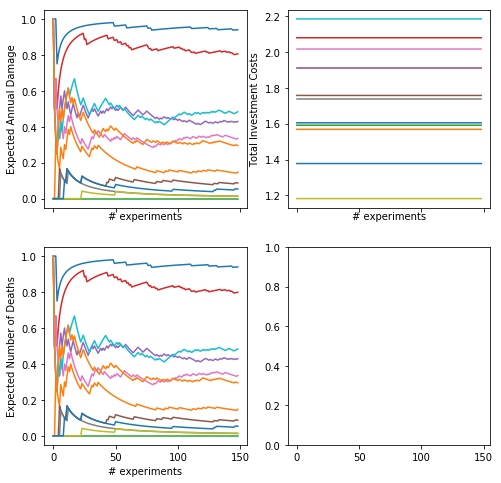

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

SMALLER = 'SMALLER'
robustness_funcs = {"Expected Number of Deaths": functools.partial(threshold, SMALLER, 0.00001),
                    "Expected Annual Damage": functools.partial(threshold, SMALLER, 100000), 
                    "Total Investment Costs": mean_rob }

# robustness_functions = [ScalarOutcome('Robustness metric Damage', kind=MAXIMIZE,
#                              variable_name='Expected Annual Damage', function = damage_funcs),
#                         ScalarOutcome('Robustness metric Dike Costs', kind=MINIMIZE,
#                              variable_name='Dike Investment Costs', function = mean_rob),
#                         ScalarOutcome('Robustness metric RfR Investement Costs', kind=MINIMIZE,
#                              variable_name='RfR Investment Costs', function = mean_rob),
#                         ScalarOutcome('Robustness metric Evacuation Costs', kind=MINIMIZE,
#                              variable_name='Evacuation Costs', function = mean_rob),
#                         ScalarOutcome('Robustness metric Deaths', kind=MAXIMIZE,
#                              variable_name='Expected Number of Deaths', function = death_funcs)]


for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [65]:
# decision_varnames = list(dike_model.levers.keys())
# outcome_varnames = ["frac_{}".format(var_name) for var_name in dike_model.outcomes.keys()]
# outcome_varnames

In [11]:
n_scenarios = 60
nfe = 6000
scenarios = sample_uncertainties(dike_model, n_scenarios)
epsilons = [0.0005, 0.0005, 0.0005, 0.0005, 0.0005]

In [13]:
%%time
BaseEvaluator.reporting_frequency = 15

# is the order of the hypervolume according to the order of the outcomes? 
convergence_metrics = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 3 , 3, 3, 1.1]),
                       EpsilonProgress()]
 
constraint = [Constraint("Death constraint", outcome_names="Robustness metric Deaths", function=lambda x:max(0, 0.75-x))]

with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilons, constraints=constraint, logging_freq = 1, convergence_freq = 10)

archive.to_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe{epsilons}")
convergence.to_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe{epsilons}")

[MainProcess/INFO] generation 0: 0/6000 nfe
[MainProcess/INFO] generation 1: 100/6000 nfe
[MainProcess/INFO] generation 2: 200/6000 nfe
[MainProcess/INFO] generation 3: 300/6000 nfe
[MainProcess/INFO] generation 4: 400/6000 nfe
[MainProcess/INFO] generation 5: 500/6000 nfe
[MainProcess/INFO] generation 6: 600/6000 nfe
[MainProcess/INFO] generation 7: 700/6000 nfe
[MainProcess/INFO] generation 8: 800/6000 nfe
[MainProcess/INFO] generation 9: 899/6000 nfe
[MainProcess/INFO] generation 10: 998/6000 nfe
[MainProcess/INFO] generation 11: 1098/6000 nfe
[MainProcess/INFO] generation 12: 1196/6000 nfe
[MainProcess/INFO] generation 13: 1296/6000 nfe
[MainProcess/INFO] generation 14: 1394/6000 nfe
[MainProcess/INFO] generation 15: 1493/6000 nfe
[MainProcess/INFO] generation 16: 1593/6000 nfe
[MainProcess/INFO] generation 17: 1691/6000 nfe
[MainProcess/INFO] generation 18: 1791/6000 nfe
[MainProcess/INFO] generation 19: 1890/6000 nfe
[MainProcess/INFO] generation 20: 1990/6000 nfe
[MainProcess/IN

Wall time: 19h 33min 41s


In [15]:
archive = pd.read_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe{epsilons}", index_col=0)
convergence = pd.read_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe{epsilons}", index_col=0)

In [20]:
#print(archive)

In [17]:
convergence

hypervolume  epsilon_progress   nfe
0      0.000000                 0     0
1      0.359840                 6   100
2      0.366449                 7   200
3      0.475737                11   300
4      0.500025                15   400
5      0.534260                22   500
6      0.604574                27   600
7      0.612825                33   700
8      0.614304                36   800
9      0.615778                40   899
10     0.626877                52   998
11     0.630761                59  1098
12     0.640734                72  1196
13     0.645400                82  1296
14     0.648449                92  1394
15     0.666478               103  1493
16     0.682067               111  1593
17     0.683338               116  1691
18     0.696640               129  1791
19     0.702853               144  1890
20     0.703614               154  1990
21     0.707059               163  2090
22     0.709464               171  2190
23     0.712319               181  2288
24     0.712944               190  2388
25     0.714129               206  2488
26     0.714269               221  2588
27     0.715295               237  2688
28     0.715512               250  2787
29     0.716364               265  2887
..          ...               ...   ...
31     0.717895               289  3085
32     0.718100               302  3183
33     0.718375               311  3283
34     0.718567               322  3383
35     0.718596               328  3483
36     0.718637               340  3583
37     0.718664               351  3683
38     0.718689               360  3781
39     0.718717               368  3881
40     0.725456               383  3981
41     0.725517               395  4081
42     0.727072               409  4181
43     0.727114               424  4281
44     0.727162               435  4380
45     0.727217               444  4479
46     0.727244               451  4579
47     0.727276               459  4678
48     0.727314               466  4777
49     0.727619               479  4876
50     0.727634               483  4976
51     0.733716               486  5075
52     0.735404               494  5174
53     0.735925               500  5274
54     0.736005               504  5374
55     0.736006               508  5473
56     0.736020               514  5571
57     0.736109               517  5671
58     0.736123               525  5771
59     0.736126               527  5870
60     0.736137               530  5969

[61 rows x 3 columns]

In [18]:
# check the found solutions
levers = archive.loc[:, [l.name for l in dike_model.levers]]
levers.T

0   1   2   3   4   5   6   7   8   9   ...  85  86  87  \
0_RfR 0              0   1   1   1   1   1   0   1   1   1  ...   0   1   0   
0_RfR 1              0   0   1   0   1   1   0   0   0   1  ...   0   1   1   
1_RfR 0              0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
1_RfR 1              0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
2_RfR 0              1   0   1   1   0   1   1   1   1   1  ...   0   1   0   
2_RfR 1              1   1   1   1   1   1   1   1   1   1  ...   1   1   1   
3_RfR 0              0   0   1   0   1   1   0   1   0   0  ...   0   0   0   
3_RfR 1              0   0   1   0   0   0   0   1   0   1  ...   0   0   0   
4_RfR 0              0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
4_RfR 1              0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
EWS_DaysToThreat     0   1   0   2   0   0   0   0   3   3  ...   1   0   3   
A.1_DikeIncrease 0   9   4   4   5   5   4   7   6   6   3  ...   6   5   4   
A.1_DikeIncrease 1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
A.2_DikeIncrease 0   9   8   7   8   6   8   9   8   9   8  ...   8   8   6   
A.2_DikeIncrease 1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
A.3_DikeIncrease 0  10   9   9  10   9   9   9   9  10   8  ...   8   9  10   
A.3_DikeIncrease 1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
A.4_DikeIncrease 0   9   9   9   9   9   9   9   8   9   9  ...   9   9   9   
A.4_DikeIncrease 1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
A.5_DikeIncrease 0   9  10   9  10   8  10   9  10  10   9  ...  10   9   9   
A.5_DikeIncrease 1   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   

                    88  89  90  91  92  93  94  
0_RfR 0              1   1   0   1   1   1   1  
0_RfR 1              1   1   0   1   0   1   0  
1_RfR 0              0   0   0   0   0   0   0  
1_RfR 1              1   0   0   1   0   0   0  
2_RfR 0              0   0   1   1   0   1   1  
2_RfR 1              1   1   0   1   1   1   1  
3_RfR 0              1   0   1   0   0   1   0  
3_RfR 1              0   0   1   0   0   1   0  
4_RfR 0              0   0   0   0   0   0   0  
4_RfR 1              0   0   0   0   0   0   0  
EWS_DaysToThreat     3   1   1   3   1   1   1  
A.1_DikeIncrease 0   0   2   9   0   5   6   7  
A.1_DikeIncrease 1   0   0   0   0   0   0   0  
A.2_DikeIncrease 0   9   6   9  10   9  10   9  
A.2_DikeIncrease 1   0   0   7   0   0   0   0  
A.3_DikeIncrease 0   9   9  10   9   8   9  10  
A.3_DikeIncrease 1   0   0   0   0   0   0   0  
A.4_DikeIncrease 0   9   9   9   9   9   9   9  
A.4_DikeIncrease 1   0   0   8   0   0   0   0  
A.5_DikeIncrease 0  10   9  10  10  10  10  10  
A.5_DikeIncrease 1   0   0   1   0   0   0   0  

[21 rows x 95 columns]

In [33]:
policies_to_evaluate = [Policy('policy'+str(i), **policy.to_dict()) 
                        for i, policy in pd.DataFrame.from_dict(levers).iterrows()]
# policies_to_evaluate

## Convergence of ε and hypervolume

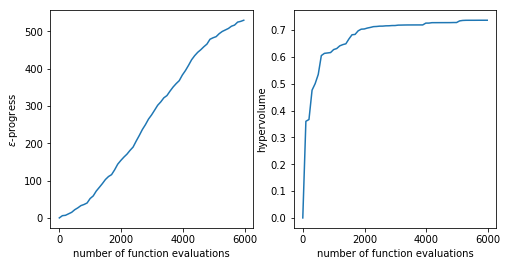

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()